In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import re
import numpy as np
import seaborn as sns
from scipy.stats import t
from statistics import mean

**TODO**
* harmonize the mutation calls for each dataset by correcting by tumour mutational burden
* plot volcano plot

In [18]:
class MutationCalls:
    
    def __init__(self, mutationsDataFrame, clinicalDataFrame):
        self.response = {}
        self.mutation = mutationsDataFrame
        self.clinical = clinicalDataFrame
        self.observedVariants = []
        self.mutationAlleleFrequencies = {}
        
        self.filterMutation = None
        self.means = None
        self.filteredResponders = []
        self.filteredNonresponders = []
        self.sortedpVals = None
        
    def sort_byResponse(self,responseColumn,sampleIndexColumn):
        typeResponse = self.clinical[responseColumn].unique()
            
        for response in typeResponse:
            indiciesResponseType = self.clinical[responseColumn] == response
            patientsResponseType = self.clinical[indiciesResponseType][sampleIndexColumn].to_list()
            
            self.response[response] = patientsResponseType
            
    def assign_byPatient(self, columnVariantAlleleFrequency=False, affix="", **cols):
        samples = itertools.chain.from_iterable(self.response.values())
    
        sampleIndexColumn = cols.get('sampleIndexColumn',None)
        geneColumn = cols.get('geneColumn',None)
        variantAlleleColumn = cols.get('variantAlleleColumn',None)
        altReadsColumn = cols.get('altReadsColumn',None)
        totalReadsColumn = cols.get('totalReadsColumn',None)
        
        if (not columnVariantAlleleFrequency):
            self.mutation["Variant_Allele_Frequency"] = self.mutation[altReadsColumn]/self.mutation[totalReadsColumn]
            variantAlleleColumn = 'Variant_Allele_Frequency'
    
        for sampl in samples:
            
            regular = re.compile(affix % sampl)
            indiciesPatientMutations = (self.mutation[sampleIndexColumn]==regular.pattern).tolist()
            #indiciesPatientMutations = [bool(re.match(regular, i)) for i in self.mutation[sampleIndexColumn]]        
            variantAlleleFrequency = self.mutation.loc[indiciesPatientMutations,[geneColumn, variantAlleleColumn]].to_records(index=False)
            variants = [gene for gene, frequency in variantAlleleFrequency]
            
            self.observedVariants.extend(variants)
            self.mutationAlleleFrequencies[sampl] = variantAlleleFrequency

    def df_toMeans(self, mutationRecurrence = 0, **labels):
       
        response = labels.get('response')
        nonresponse = labels.get('nonresponse')
        geneColumn = labels.get('geneColumn')
        variantAlleleColumn = labels.get('variantAlleleColumn')
        
        columns = list(itertools.chain.from_iterable([self.response[response] for response in self.response.keys()]))
        index = list(set(self.observedVariants))
        
        variantAlleleMatrix = []
    
        for col in columns:
        
            df_GeneVaf = pd.DataFrame(self.mutationAlleleFrequencies[col])
            df_GeneVaf_GroupedBy = df_GeneVaf.groupby([geneColumn]).mean()
            vafdict = df_GeneVaf_GroupedBy.to_dict()[variantAlleleColumn]
            variantAlleleMatrix.append([vafdict[m] if m in vafdict.keys() else np.NaN for m in index])
            # variantAlleleMatrix.append([vafdict[m] if m in vafdict.keys() else 0 for m in index])
            # 6/10/22 do not average over all samples, instead only those which have detectable mutations i.e., alt read > 0
            # T test ?
    
        df = pd.DataFrame(variantAlleleMatrix).T
        df.columns = columns
        df.index = index
       
        # return df
        mean_dupes = df[(df.fillna(0) != 0).sum(axis=1) >= mutationRecurrence] # in at least 3 tumours across both responders and nonresponders
        
        # return mean_dupes

        response_columns = itertools.chain.from_iterable([self.response[i] for i in response])
        nonresponse_columns = itertools.chain.from_iterable([self.response[i] for i in nonresponse])
        
        filtered_patients = mean_dupes
        filtered_patients = filtered_patients[filtered_patients.sum(axis=1) != 0]

        response_columns_postFilter = [i for i in response_columns if i in filtered_patients.columns]
        nonresponse_columns_postFilter = [i for i in nonresponse_columns if i in filtered_patients.columns]

        # return (filtered_patients.loc[:,response_columns_postFilter])

        means = pd.concat([filtered_patients.loc[:,response_columns_postFilter].mean(axis=1), filtered_patients.loc[:,nonresponse_columns_postFilter].mean(axis=1)], axis=1)
        means.columns = ["response", "nonresponse"]
        
        self.filterMutation = filtered_patients
        self.means = means
        self.filteredResponders = response_columns_postFilter
        self.filteredNonresponders = nonresponse_columns_postFilter
    
    def tTest(self):

        # degfre = (self.filterMutation.fillna(0).astype(bool).sum(axis=1)) - 2
        degfre = len(self.filteredResponders) + len(self.filteredNonresponders) - 2
        print(degfre)
        tvalueSeries = twosample_test(dataframe=self.filterMutation, category_columns={'response':self.filteredResponders, 'nonresponse':self.filteredNonresponders})
        
        pvalueSeries = tstat_to_pvalue(tvalueSeries, df=degfre)
        sorted_pvals = pvalueSeries.sort_values(ascending=True)
        
        self.sortedpVals = sorted_pvals

In [19]:
class TumourMutationalBurden:
    
    def __init__(self, mutation_table):
        self.mutation_table = mutation_table
        self.nssnv_counts = None
        
    def count_nonsynonomous_mutations(self, label_column):
        labels = self.mutation_table[label_column]
        unique, counts = np.unique(labels, return_counts=True)
        self.nssnv_counts = dict(zip(unique, counts))

In [20]:
def twosample_test(dataframe, category_columns, pvalue=False):
    
    dataframe["l_count"] = (dataframe.loc[:,category_columns["response"]].fillna(0).astype(bool).sum(axis=1))
    dataframe["r_count"] = (dataframe.loc[:,category_columns["nonresponse"]].fillna(0).astype(bool).sum(axis=1))

    sampl_means = {label: dataframe[columns].mean(axis=1) for label, columns in category_columns.items()}
    sampl_stdevs = {label: dataframe[columns].std(axis=1) for label, columns in category_columns.items()}
    
    t_stats = ((sampl_means['response'] - sampl_means['nonresponse']) / np.sqrt((sampl_stdevs["response"]**2/dataframe["l_count"])+(sampl_stdevs["nonresponse"]**2/dataframe["r_count"])))
    
    return t_stats

def tstat_to_pvalue(t_stat, df):
    
    t_tuples = list(zip(t_stat.index, t_stat))
    p_values = {i: t.sf(abs(v), df=df)*2 for i, v in t_tuples}
    
    return pd.Series(data=p_values)

## Snyder

In [29]:
# preprocess datatable
mutation_table = pd.read_csv('mutation-calls-merged-vcf/snyder-2018-sneff.tsv', sep='\t', header=None, index_col=0)
clinical_features = pd.read_csv('mutation-calls-merged-vcf/snyder-2018-clinical-characteristics.csv')
mutation_table.reset_index(inplace=True)
mutation_table.columns = ["MUT.IDX","CHROM","POS","REF","ALT","START","END","Allele","Annotation","Gene_Name","Feature_Type","Transcript_BioType","HGVS.c","HGVS.p","baseline_TOTAL_READS","baseline_MUTANT_READS","normal_TOTAL_READS","normal_MUTANT_READS","Sample_Name"]
mutation_table.dropna(subset=['Sample_Name'],inplace=True)

In [30]:
mutation_table = mutation_table[mutation_table['Feature_Type'] == 'transcript']
mutation_table = mutation_table[~mutation_table['Annotation'].str.contains('synonymous')]
mutation_table = mutation_table[mutation_table['CHROM'] != 'chrM']
mutation_table = mutation_table[mutation_table['baseline_MUTANT_READS'] != 0]

In [31]:
# create instance
snyder = MutationCalls(mutation_table, clinical_features)
snyder.sort_byResponse('Benefit', 'Study ID')

columns = {"sampleIndexColumn": 'Sample_Name', 
           "geneColumn": 'Gene_Name',
           "altReadsColumn": 'baseline_MUTANT_READS',
           "totalReadsColumn": 'baseline_TOTAL_READS'}

snyder.assign_byPatient(False, affix='%s', **columns)   


In [32]:
snyder.df_toMeans(mutationRecurrence=3, response=[True], nonresponse=[False], geneColumn = 'Gene_Name', variantAlleleColumn = 'Variant_Allele_Frequency')

In [33]:
# T test
snyder.tTest()
# filter p-values
sorted_pvals = snyder.sortedpVals
means = snyder.means

indicesSignificantGenes = sorted_pvals[sorted_pvals <= 1].index
snyder_sorted_p = means.reindex(indicesSignificantGenes)
#sorted_p[sorted_p.eq(0)] = np.nan

62


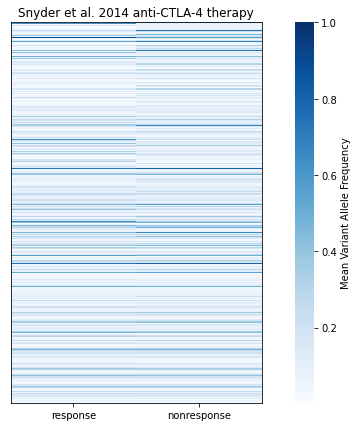

In [11]:
ax = sns.heatmap(snyder_sorted_p,cmap="Blues", cbar_kws={'label': 'Mean Variant Allele Frequency', "pad": 0.1}, yticklabels=False)
ax.figure.set_size_inches((6, 7))
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_title('Snyder et al. 2014 anti-CTLA-4 therapy')

for _, spine in ax.spines.items():
    spine.set_visible(True)
    
plt.savefig('/Users/wuchh/Downloads/snyder-mean-vaf.png', facecolor='white', bbox_inches='tight', dpi=300)

In [12]:
snyder_sorted_p["p-values"] = sorted_pvals
snyder_sorted_p.columns = ['responders','non-responders','p-value']

In [29]:
snyder.mutation[snyder.mutation["Gene_Name"] == "PHKA2"]

,MUT.IDX,CHROM,POS,REF,ALT,START,END,Allele,Annotation,Gene_Name,Feature_Type,Transcript_BioType,HGVS.c,HGVS.p,baseline_TOTAL_READS,baseline_MUTANT_READS,normal_TOTAL_READS,normal_MUTANT_READS,Sample_Name,Variant_Allele_Frequency
36485,mut26104,chrX,18937984,CATTTTATTCATTTTAATATATGCAAGTTTCAGAAGCCTCTTTTTT...,['C'],18937984,18938082,C,intron_variant,PHKA2,transcript,protein_coding,c.1963+68_1963+165delTGCCCTAAGACTCAAATATAGACAA...,NaN,286,7,56,7,CR04885,0.024476
134065,mut45948,chrX,18919644,C,['CCCGACTGTTAACACTACTGGTTATATTGACCATGCCGCTTTTC...,18919644,18919644,CCCGACTGTTAACACTACTGGTTATATTGACCATGCCGCTTTTCTT...,frameshift_variant&stop_gained,PHKA2,transcript,protein_coding,c.2985_2986insTAATCGTGCCAAGAAAAGCGGCATGGTCAATA...,p.Glu996fs,48,2,62,2,CR4880,0.041667
269298,mut12484,chrX,18929128,CTTT,"['C', 'CT', 'CTT']",18929128,18929131,C,intron_variant,PHKA2,transcript,protein_coding,c.2138-53_2138-51delAAA,NaN,34,32,92,84,CRNR4941,0.941176
468521,mut10012,chrX,18929128,CTTT,"['C', 'CTT']",18929128,18929131,C,intron_variant,PHKA2,transcript,protein_coding,c.2138-53_2138-51delAAA,NaN,22,21,29,26,NR4018,0.954545
797892,mut25579,chrX,18929128,CTT,['C'],18929128,18929130,C,intron_variant,PHKA2,transcript,protein_coding,c.2138-52_2138-51delAA,NaN,31,1,26,2,PR4092,0.032258
820247,mut13949,chrX,18919644,C,['CCCGACTGTTAACACTACTGGTTATATTGACCATGCCGCTTTTC...,18919644,18919644,CCCGACTGTTAACACTACTGGTTATATTGACCATGCCGCTTTTCTT...,frameshift_variant&stop_gained,PHKA2,transcript,protein_coding,c.2985_2986insTAATCGTGCCAAGAAAAGCGGCATGGTCAATA...,p.Glu996fs,57,1,82,3,SD1494,0.017544


In [30]:
"NR4018" in snyder.response[True]

False

In [31]:
VAFarray = snyder.filterMutation.T.iloc[:-2,:]
response_column = [0 for i in snyder.response[True]] + [1 for i in snyder.response[False]]
VAFarray['response'] = response_column
snyder_sorted_p['ratio'] = snyder_sorted_p['responders'] / snyder_sorted_p['non-responders']
snyder_sorted_p['log2 Ratio Group Means'] = np.log2(snyder_sorted_p['ratio'])
snyder_sorted_p['-log10 (p-values)'] = -1 * np.log10(snyder_sorted_p['p-value'])

snyder_sorted_p['significant_genes'] = [0] * snyder_sorted_p.shape[0]
snyder_sorted_p.loc[snyder_sorted_p["p-value"] <= 0.05, "significant_genes"] = 1
snyder_sorted_p

,responders,non-responders,p-value,ratio,log2 Ratio Group Means,-log10 (p-values),significant_genes
PHKA2,0.028986,0.947861,1.885096e-72,0.030580,-5.031246,71.724666,1
LAIR2,0.027047,0.068337,1.899071e-54,0.395783,-1.337220,53.721459,1
GAREM2,0.033644,0.241543,8.313624e-18,0.139287,-2.843866,17.080210,1
CCT6A,0.036129,0.105180,1.113205e-15,0.343497,-1.541632,14.953425,1
SVOPL,0.011313,0.458333,1.259287e-15,0.024683,-5.340313,14.899875,1
...,...,...,...,...,...,...,...
CTSZ,0.195315,0.195564,9.983835e-01,0.998727,-0.001838,0.000703,0
TRAF3IP1,0.313531,0.313361,9.986714e-01,1.000541,0.000781,0.000577,0
EVI5,0.076313,0.076343,9.988275e-01,0.999604,-0.000571,0.000510,0
PSG4,0.027407,0.027414,9.991059e-01,0.999747,-0.000366,0.000388,0


In [32]:
snyder_sorted_p.to_csv("/Users/wuchh/Downloads/snyder-mean-vaf-ranked.csv", sep=',')

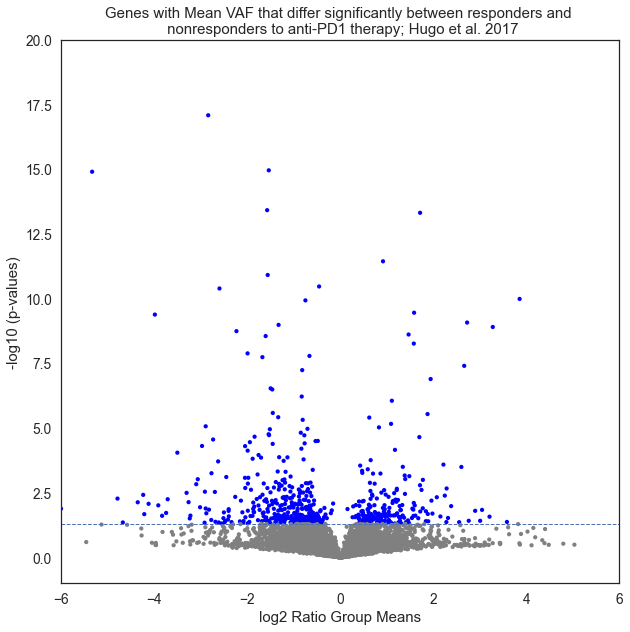

In [33]:
sns.set(font_scale = 1.25)
sns.set_style("white")
ax = sns.scatterplot(x=snyder_sorted_p['log2 Ratio Group Means'], y=snyder_sorted_p['-log10 (p-values)'],linewidth=0, alpha=1, size = 20, hue=snyder_sorted_p['significant_genes'], legend=False, palette=['grey','blue'])
ax.figure.set_size_inches((10, 10))

ax.set_title("Genes with Mean VAF that differ significantly between responders and \n nonresponders to anti-PD1 therapy; Hugo et al. 2017", loc='center')
ax.axhline(1.30103, color='b', linestyle='--', linewidth=1)

ax.set(xlim=(-6,6), ylim=(-1,20))
plt.savefig('/Users/wuchh/Downloads/snyder-figure2.png', facecolor='white', bbox_inches='tight', dpi=300)

## Van Allen

In [5]:
# preprocess datatable
mutation_table = pd.read_csv("mutation-calls-merged-vcf/vanallen-2017-sneff.tsv", sep='\t', header=0, index_col=0)
clinical_features = pd.read_csv("mutation-calls-merged-vcf/vanallen-2017-clinical-characteristics.csv")
mutation_table.dropna(subset=['Sample_ID'],inplace=True)

In [6]:
mutation_table = mutation_table[mutation_table['Feature_Type'] == 'transcript']
mutation_table = mutation_table[~mutation_table['Annotation'].str.contains('synonymous')]
mutation_table = mutation_table[mutation_table['#CHROM'] != 'chrM']
mutation_table = mutation_table[mutation_table['baseline_ALT_READS'] != 0]

In [7]:
clinical_features["group"].unique()

array(['response', 'nonresponse', 'long-survival'], dtype=object)

In [8]:
select = mutation_table["Sample_ID"].unique().tolist()
clinical_features = clinical_features[clinical_features.patient.isin(select)]
clinical_features = clinical_features[clinical_features["RECIST"] != "X"]

In [9]:
# create instance
vanallen = MutationCalls(mutation_table, clinical_features)
vanallen.sort_byResponse('group', 'patient')

columns = {"sampleIndexColumn": 'Sample_ID', 
           "geneColumn": 'Gene_Name',
           "altReadsColumn": 'baseline_ALT_READS',
           "totalReadsColumn": 'baseline_TOTAL_READS'}
           
vanallen.assign_byPatient(False, affix='%s', **columns)

In [10]:
vanallen.df_toMeans(mutationRecurrence=3, response=['response', 'long-survival'], nonresponse=['nonresponse'], geneColumn = 'Gene_Name', variantAlleleColumn = 'Variant_Allele_Frequency')
# vanallen.df_toMeans(mutationRecurrence=3, response=['PR','CR'], nonresponse=['PD','SD'], geneColumn = 'Gene_Name', variantAlleleColumn = 'Variant_Allele_Frequency')

In [11]:
# T test
vanallen.tTest()
# filter p-values
sorted_pvals = vanallen.sortedpVals
means = vanallen.means

indicesSignificantGenes = sorted_pvals[sorted_pvals <= 1].index
vanallen_sorted_p = means.reindex(indicesSignificantGenes)
#sorted_p[sorted_p.eq(0)] = np.nan

83


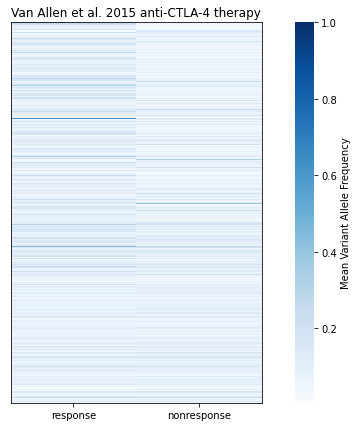

In [13]:
ax = sns.heatmap(vanallen_sorted_p,cmap="Blues", cbar_kws={'label': 'Mean Variant Allele Frequency', "pad": 0.1}, yticklabels=False)
ax.figure.set_size_inches((6, 7))
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_title('Van Allen et al. 2015 anti-CTLA-4 therapy')

for _, spine in ax.spines.items():
    spine.set_visible(True)
    
plt.savefig('/Users/wuchh/Downloads/van-allen-mean-vaf.png', facecolor='white', bbox_inches='tight', dpi=300)

In [14]:
vanallen_sorted_p["p-values"] = sorted_pvals
vanallen_sorted_p.columns = ['responders','non-responders','p-value']

In [15]:
vanallen_sorted_p[vanallen_sorted_p["p-value"]<=0.05]#.to_csv("/Users/dch/Downloads/antiPD1_riaz.txt")
# riaz_sorted_p.to_csv("/Users/dch/Downloads/riaz_means_pvalue.csv")

,responders,non-responders,p-value
MIR6787,0.084821,1.000000,7.300560e-57
VHL,0.109145,0.018649,1.734075e-30
YPEL5,0.115943,0.005682,7.581066e-30
GJB4,0.238924,0.043754,4.588022e-29
GTF2H5,0.015384,0.075615,3.808909e-26
...,...,...,...
OGDHL,0.242873,0.099346,4.962682e-02
DMTF1,0.129555,0.053501,4.977558e-02
ZNF334,0.071750,0.204494,4.981378e-02
HPGD,0.082178,0.029765,4.984342e-02


In [16]:
VAFarray = vanallen.filterMutation.T.iloc[:-2,:]
response_column = [0 for i in vanallen.response['response']] + [1 for i in vanallen.response['nonresponse']] + [0 for i in vanallen.response['long-survival']]
VAFarray['response'] = response_column
vanallen_sorted_p['ratio'] = vanallen_sorted_p['responders'] / vanallen_sorted_p['non-responders']
vanallen_sorted_p['log2 Ratio Group Means'] = np.log2(vanallen_sorted_p['ratio'])
vanallen_sorted_p['-log10 (p-values)'] = -1 * np.log10(vanallen_sorted_p['p-value'])

vanallen_sorted_p['significant_genes'] = [0] * vanallen_sorted_p.shape[0]
vanallen_sorted_p.loc[vanallen_sorted_p["p-value"] <= 0.05, "significant_genes"] = 1
vanallen_sorted_p

,responders,non-responders,p-value,ratio,log2 Ratio Group Means,-log10 (p-values),significant_genes
MIR6787,0.084821,1.000000,7.300560e-57,0.084821,-3.559427,56.136644,1
VHL,0.109145,0.018649,1.734075e-30,5.852583,2.549073,29.760932,1
YPEL5,0.115943,0.005682,7.581066e-30,20.407043,4.350995,29.120270,1
GJB4,0.238924,0.043754,4.588022e-29,5.460560,2.449049,28.338375,1
GTF2H5,0.015384,0.075615,3.808909e-26,0.203451,-2.297244,25.419199,1
...,...,...,...,...,...,...,...
KBTBD8,0.066005,0.065989,9.996106e-01,1.000239,0.000344,0.000169,0
CD200,0.052573,0.052567,9.998436e-01,1.000117,0.000169,0.000068,0
RHOBTB3,0.089540,0.089535,9.999385e-01,1.000047,0.000068,0.000027,0
MGAM,0.191922,0.191917,9.999508e-01,1.000025,0.000035,0.000021,0


In [20]:
vanallen_sorted_p.to_csv("/Users/wuchh/Downloads/van-allen-mean-vaf-ranked.csv", sep=',')

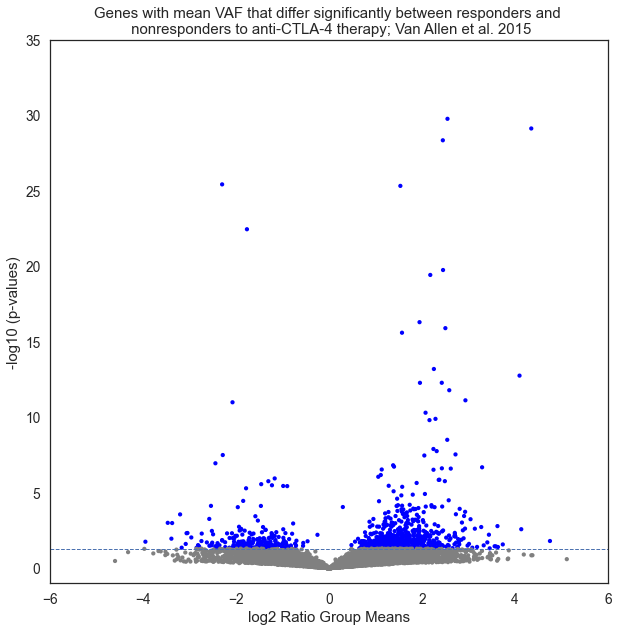

In [18]:
sns.set(font_scale = 1.25)
sns.set_style("white")
ax = sns.scatterplot(x=vanallen_sorted_p['log2 Ratio Group Means'], y=vanallen_sorted_p['-log10 (p-values)'],linewidth=0, alpha=1, size = 20, hue=vanallen_sorted_p['significant_genes'], legend=False, palette=['grey','blue'])
ax.figure.set_size_inches((10, 10))

ax.set(xlim=(-6,6), ylim=(-1,35))

ax.set_title("Genes with mean VAF that differ significantly between responders and \n nonresponders to anti-CTLA-4 therapy; Van Allen et al. 2015", loc='center') 
ax.axhline(1.30103, color='b', linestyle='--', linewidth=1)

plt.savefig('/Users/wuchh/Downloads/van-allen-figure2.png', facecolor='white', bbox_inches='tight', dpi=300)

## Hugo

In [34]:
# preprocess datatable
mutation_table = pd.read_csv('mutation-calls-merged-vcf/hugo-2016-sneff.tsv', sep='\t', header=None, index_col=0)
clinical_features = pd.read_csv('mutation-calls-merged-vcf/hugo-2016-clinical-characteristics.csv')
mutation_table.reset_index(inplace=True)
mutation_table.columns = ["MUT.IDX","CHROM","POS","REF","ALT","START","END","Allele","Annotation","Gene_Name","Feature_Type","Transcript_BioType","HGVS.c","HGVS.p","baseline_TOTAL_READS","baseline_MUTANT_READS","normal_TOTAL_READS","normal_MUTANT_READS","Sample_Name"]
mutation_table.dropna(subset=['Sample_Name'],inplace=True)

In [35]:
mutation_table = mutation_table[mutation_table['Feature_Type'] == 'transcript']
mutation_table = mutation_table[~mutation_table['Annotation'].str.contains('synonymous')]
mutation_table = mutation_table[mutation_table['CHROM'] != 'chrM']
mutation_table = mutation_table[mutation_table['baseline_MUTANT_READS'] != 0]

In [36]:
# create instance
hugo = MutationCalls(mutation_table, clinical_features)
hugo.sort_byResponse('irRECIST', 'Patient ID')

columns = {"sampleIndexColumn": 'Sample_Name', 
           "geneColumn": 'Gene_Name',
           "altReadsColumn": 'baseline_MUTANT_READS',
           "totalReadsColumn": 'baseline_TOTAL_READS'}

hugo.assign_byPatient(False, affix='%s', **columns)   


In [37]:
hugo.df_toMeans(mutationRecurrence=3, response=['Partial Response','Complete Response'], nonresponse=['Progressive Disease'], geneColumn = 'Gene_Name', variantAlleleColumn = 'Variant_Allele_Frequency')

In [38]:
# T test
hugo.tTest()
# filter p-values
sorted_pvals = hugo.sortedpVals
means = hugo.means

indicesSignificantGenes = sorted_pvals[sorted_pvals <= 1].index
hugo_sorted_p = means.reindex(indicesSignificantGenes)
#sorted_p[sorted_p.eq(0)] = np.nan

36


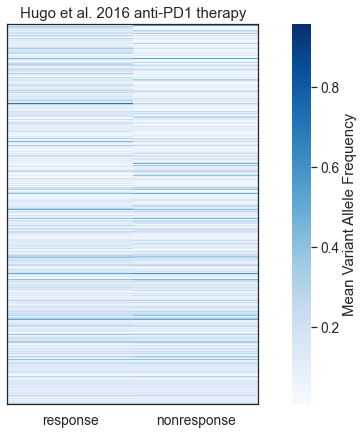

In [39]:
ax = sns.heatmap(hugo_sorted_p,cmap="Blues", cbar_kws={'label': 'Mean Variant Allele Frequency', "pad": 0.1}, yticklabels=False)
ax.figure.set_size_inches((6, 7))
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_title('Hugo et al. 2016 anti-PD1 therapy')

for _, spine in ax.spines.items():
    spine.set_visible(True)
    
plt.savefig('/Users/wuchh/Downloads/hugo-mean-vaf.png', facecolor='white', bbox_inches='tight', dpi=300)

In [40]:
hugo_sorted_p["p-values"] = sorted_pvals
hugo_sorted_p.columns = ['responders','non-responders','p-value']

In [41]:
hugo_sorted_p
# hugo_sorted_p.to_csv("/Users/dch/Downloads/hugo_means_pvalue.csv")

,responders,non-responders,p-value
LOC105373878,0.043106,0.666667,2.485087e-26
ABHD14A,0.286458,0.067960,4.295254e-21
GRASP,0.010686,0.410215,1.062090e-18
C2orf50,0.113192,0.958333,1.906447e-16
MIR558,0.071057,0.011830,2.327993e-14
...,...,...,...
ESPL1,0.051100,0.051116,9.995784e-01
CLDN14,0.210599,0.210560,9.996118e-01
NIBAN1,0.130601,0.130582,9.997887e-01
ABCA12,0.196397,0.196390,9.998709e-01


In [42]:
# hugo.filterMutation.to_csv("/Users/dch/Downloads/hugo_individual_VAFs.csv")

In [43]:
VAFarray = hugo.filterMutation.T.iloc[:-2,:]
response_column = [0 for i in hugo.response['Progressive Disease']] + [1 for i in hugo.response['Partial Response']] + [1 for i in hugo.response['Complete Response']]
VAFarray['response'] = response_column
hugo_sorted_p['ratio'] = hugo_sorted_p['responders'] / hugo_sorted_p['non-responders']
hugo_sorted_p['log2 Ratio Group Means'] = np.log2(hugo_sorted_p['ratio'])
hugo_sorted_p['-log10 (p-values)'] = -1 * np.log10(hugo_sorted_p['p-value'])

hugo_sorted_p['significant_genes'] = [0] * hugo_sorted_p.shape[0]
hugo_sorted_p.loc[hugo_sorted_p["p-value"] <= 0.05, "significant_genes"] = 1
hugo_sorted_p

,responders,non-responders,p-value,ratio,log2 Ratio Group Means,-log10 (p-values),significant_genes
LOC105373878,0.043106,0.666667,2.485087e-26,0.064659,-3.951011,25.604658,1
ABHD14A,0.286458,0.067960,4.295254e-21,4.215072,2.075557,20.367011,1
GRASP,0.010686,0.410215,1.062090e-18,0.026050,-5.262578,17.973838,1
C2orf50,0.113192,0.958333,1.906447e-16,0.118113,-3.081755,15.719775,1
MIR558,0.071057,0.011830,2.327993e-14,6.006553,2.586537,13.633018,1
...,...,...,...,...,...,...,...
ESPL1,0.051100,0.051116,9.995784e-01,0.999693,-0.000443,0.000183,0
CLDN14,0.210599,0.210560,9.996118e-01,1.000187,0.000270,0.000169,0
NIBAN1,0.130601,0.130582,9.997887e-01,1.000143,0.000206,0.000092,0
ABCA12,0.196397,0.196390,9.998709e-01,1.000039,0.000057,0.000056,0


In [45]:
# hugo_sorted_p[hugo_sorted_p["p-value"]<=0.05].to_csv("/Users/dch/Downloads/antiPD1_hugo.txt")
#sorted_p.to_csv("/Users/dch/Downloads/antiPD1_hugo_means_pvalue.csv")
hugo_sorted_p.to_csv("/Users/wuchh/Downloads/hugo-mean-vaf-ranked.csv", sep=',')

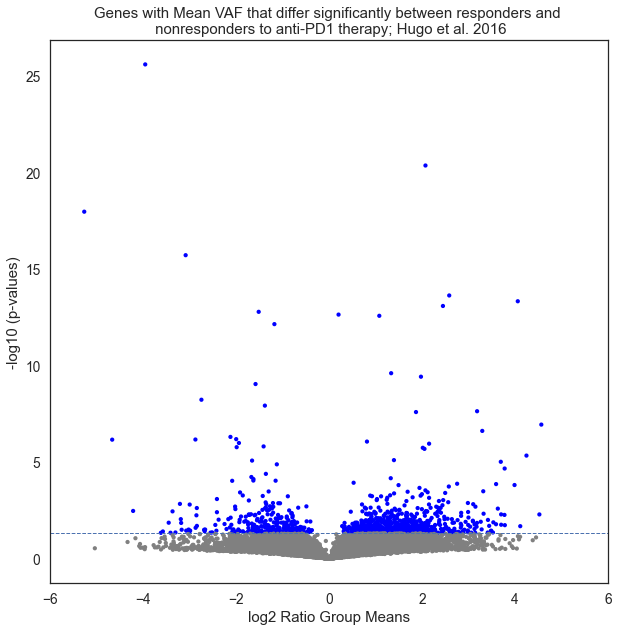

In [64]:
sns.set(font_scale = 1.25)
sns.set_style("white")
ax = sns.scatterplot(x=hugo_sorted_p['log2 Ratio Group Means'], y=hugo_sorted_p['-log10 (p-values)'],linewidth=0, alpha=1, size = 20, hue=hugo_sorted_p['significant_genes'], legend=False, palette=['grey','blue'])
ax.figure.set_size_inches((10, 10))

ax.set_title("Genes with Mean VAF that differ significantly between responders and \n nonresponders to anti-PD1 therapy; Hugo et al. 2016", loc='center')
ax.axhline(1.30103, color='b', linestyle='--', linewidth=1)

ax.set(xlim=(-6,6))
plt.savefig('/Users/wuchh/Downloads/hugo-figure2.png', facecolor='white', bbox_inches='tight', dpi=300)

In [ ]:
hugo_sorted_p[hugo_sorted_p["significant_genes"] == 1].index.to_list()

## Riaz

In [65]:
# preprocess datatable
mutation_table = pd.read_csv("mutation-calls-merged-vcf/riaz-2014-sneff.tsv", sep='\t', header=0, index_col=0)
clinical_features = pd.read_csv("mutation-calls-merged-vcf/riaz-2014-clinical-characteristics.csv")
mutation_table.dropna(subset=['Sample_ID'],inplace=True)

In [66]:
clinical_features["Cohort"].unique()

array(['NIV3-PROG', 'NIV3-NAIVE'], dtype=object)

In [67]:
mutation_table = mutation_table[mutation_table['Feature_Type'] == 'transcript']
mutation_table = mutation_table[~mutation_table['Annotation'].str.contains('synonymous')]
mutation_table = mutation_table[mutation_table['#CHROM'] != 'chrM']
mutation_table = mutation_table[mutation_table['baseline_ALT_READS'] != 0]

In [68]:
select = mutation_table["Sample_ID"].unique().tolist()
clinical_features = clinical_features[clinical_features.Patient.isin(select)]
clinical_features = clinical_features[clinical_features["Response"] != "NE"]

In [69]:
# create instance
riaz = MutationCalls(mutation_table, clinical_features)
riaz.sort_byResponse('Response', 'Patient')

columns = {"sampleIndexColumn": 'Sample_ID', 
           "geneColumn": 'Gene_Name',
           "altReadsColumn": 'baseline_ALT_READS',
           "totalReadsColumn": 'baseline_TOTAL_READS'}
           
riaz.assign_byPatient(False, affix='%s', **columns)

In [70]:
riaz.df_toMeans(mutationRecurrence=3, response=['PR','CR'], nonresponse=['PD','SD'], geneColumn = 'Gene_Name', variantAlleleColumn = 'Variant_Allele_Frequency')

In [71]:
riaz.filterMutation

,Pt100,Pt103,Pt106,Pt11,Pt13,Pt17,Pt24,Pt25,Pt27,Pt28,...,Pt44,Pt49,Pt53,Pt54,Pt68,Pt7,Pt72,Pt30,Pt48,Pt94
OAS3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.082031,NaN,NaN,NaN,0.485592,0.333333,0.090909,NaN,NaN
MRPL21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.284264,0.058824,NaN,NaN,NaN,NaN,NaN
MCM3AP-AS1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.045027,NaN,NaN,0.070175,NaN,NaN,NaN,NaN,0.043478
CPED1,NaN,NaN,0.041639,NaN,NaN,NaN,NaN,NaN,0.241135,0.041667,...,NaN,0.137363,NaN,0.301563,NaN,0.126463,NaN,NaN,NaN,0.068839
OR6B2,NaN,0.066667,NaN,NaN,NaN,0.142704,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.117504,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PLXDC1,NaN,NaN,NaN,NaN,NaN,0.073171,NaN,NaN,NaN,NaN,...,NaN,0.038462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.115385
UBE2V2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.040996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.400000
RUFY1,NaN,NaN,NaN,NaN,NaN,NaN,0.210526,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.176923,NaN,NaN,NaN,0.103448,NaN
MMP14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.305556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.068966


In [72]:
# T test
riaz.tTest()
# filter p-values
sorted_pvals = riaz.sortedpVals
means = riaz.means

indicesSignificantGenes = sorted_pvals[sorted_pvals <= 1].index
riaz_sorted_p = means.reindex(indicesSignificantGenes)
#sorted_p[sorted_p.eq(0)] = np.nan

60


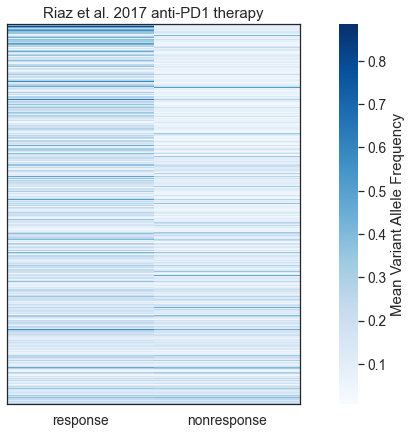

In [73]:
ax = sns.heatmap(riaz_sorted_p,cmap="Blues", cbar_kws={'label': 'Mean Variant Allele Frequency', "pad": 0.1}, yticklabels=False)
ax.figure.set_size_inches((7, 7))
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_title('Riaz et al. 2017 anti-PD1 therapy')

for _, spine in ax.spines.items():
    spine.set_visible(True)
    
plt.savefig('/Users/wuchh/Downloads/riaz-mean-vaf.png', facecolor='white', bbox_inches='tight', dpi=300)

In [74]:
riaz_sorted_p["p-values"] = sorted_pvals
riaz_sorted_p.columns = ['responders','non-responders','p-value']

In [75]:
riaz_sorted_p[riaz_sorted_p["p-value"]<=0.05]#.to_csv("/Users/dch/Downloads/antiPD1_riaz.txt")
# riaz_sorted_p.to_csv("/Users/dch/Downloads/riaz_means_pvalue.csv")

,responders,non-responders,p-value
SOST,0.248157,0.016018,7.258680e-58
C4orf32,0.312436,0.037769,8.154107e-39
CPLX2,0.365020,0.036929,3.056261e-38
MEG3,0.696216,0.059285,3.631322e-37
SLC37A3,0.469529,0.082815,4.440090e-34
...,...,...,...
SLC5A11,0.386551,0.198791,4.970141e-02
INVS,0.208855,0.076143,4.977042e-02
VEGFC,0.319614,0.056537,4.981335e-02
TBXAS1,0.258166,0.074471,4.990501e-02


In [76]:
# riaz.filterMutation.to_csv("/Users/dch/Downloads/riaz_individual_VAFs.csv")

In [77]:
# riaz.response['PD'] 
# riaz.response['SD'] 
# riaz.response['PR']
# riaz.response['CR']

In [78]:
riaz.mutation.loc[(riaz.mutation["Gene_Name"] == "SOST") & (riaz.mutation["Sample_ID"].isin(riaz.response["PR"]+riaz.response["CR"]))]

,#CHROM,POS,REF,ALT,Annotation,Gene_Name,Feature_Type,Feature_ID,Transcript_BioType,HGVS.c,HGVS.p,normal_REF_READS,normal_ALT_READS,normal_TOTAL_READS,baseline_REF_READS,baseline_ALT_READS,baseline_TOTAL_READS,Sample_ID,Variant_Allele_Frequency
5027,chr17,43755512,TGC,T,frameshift_variant,SOST,transcript,NM_025237.2,protein_coding,c.470_471delGC,p.Arg157fs,69,0,69,187,6,193,Pt7,0.031088
5028,chr17,43758536,G,A,missense_variant,SOST,transcript,NM_025237.2,protein_coding,c.206C>T,p.Pro69Leu,79,0,79,147,126,273,Pt7,0.461538
4683,chr17,43758898,GG,AA,upstream_gene_variant,SOST,transcript,NM_025237.2,protein_coding,c.-158_-157delCCinsTT,NaN,18,0,18,6,2,8,Pt72,0.250000


In [79]:
VAFarray = riaz.filterMutation.T.iloc[:-2,:]
response_column = [0 for i in riaz.response['PD']] + [0 for i in riaz.response['SD']] + [1 for i in riaz.response['PR']] + [1 for i in riaz.response['CR']]
VAFarray['response'] = response_column
riaz_sorted_p['ratio'] = riaz_sorted_p['responders'] / riaz_sorted_p['non-responders']
riaz_sorted_p['log2 Ratio Group Means'] = np.log2(riaz_sorted_p['ratio'])
riaz_sorted_p['-log10 (p-values)'] = -1 * np.log10(riaz_sorted_p['p-value'])

riaz_sorted_p['significant_genes'] = [0] * riaz_sorted_p.shape[0]
riaz_sorted_p.loc[riaz_sorted_p["p-value"] <= 0.05, "significant_genes"] = 1
riaz_sorted_p

,responders,non-responders,p-value,ratio,log2 Ratio Group Means,-log10 (p-values),significant_genes
SOST,0.248157,0.016018,7.258680e-58,15.492013,3.953453,57.139142,1
C4orf32,0.312436,0.037769,8.154107e-39,8.272289,3.048287,38.088624,1
CPLX2,0.365020,0.036929,3.056261e-38,9.884487,3.305166,37.514810,1
MEG3,0.696216,0.059285,3.631322e-37,11.743524,3.553793,36.439935,1
SLC37A3,0.469529,0.082815,4.440090e-34,5.669583,2.503243,33.352608,1
...,...,...,...,...,...,...,...
LOC101927286,0.337948,0.338011,9.996704e-01,0.999811,-0.000272,0.000143,0
CBFB,0.176798,0.176771,9.998505e-01,1.000153,0.000221,0.000065,0
AFF2,0.300070,0.300028,9.998787e-01,1.000138,0.000200,0.000053,0
AQR,0.144653,0.144661,9.999351e-01,0.999940,-0.000087,0.000028,0


In [80]:
riaz_sorted_p

,responders,non-responders,p-value,ratio,log2 Ratio Group Means,-log10 (p-values),significant_genes
SOST,0.248157,0.016018,7.258680e-58,15.492013,3.953453,57.139142,1
C4orf32,0.312436,0.037769,8.154107e-39,8.272289,3.048287,38.088624,1
CPLX2,0.365020,0.036929,3.056261e-38,9.884487,3.305166,37.514810,1
MEG3,0.696216,0.059285,3.631322e-37,11.743524,3.553793,36.439935,1
SLC37A3,0.469529,0.082815,4.440090e-34,5.669583,2.503243,33.352608,1
...,...,...,...,...,...,...,...
LOC101927286,0.337948,0.338011,9.996704e-01,0.999811,-0.000272,0.000143,0
CBFB,0.176798,0.176771,9.998505e-01,1.000153,0.000221,0.000065,0
AFF2,0.300070,0.300028,9.998787e-01,1.000138,0.000200,0.000053,0
AQR,0.144653,0.144661,9.999351e-01,0.999940,-0.000087,0.000028,0


In [81]:
riaz_sorted_p.to_csv("/Users/wuchh/Downloads/riaz-mean-vaf-ranked.csv", sep=',')

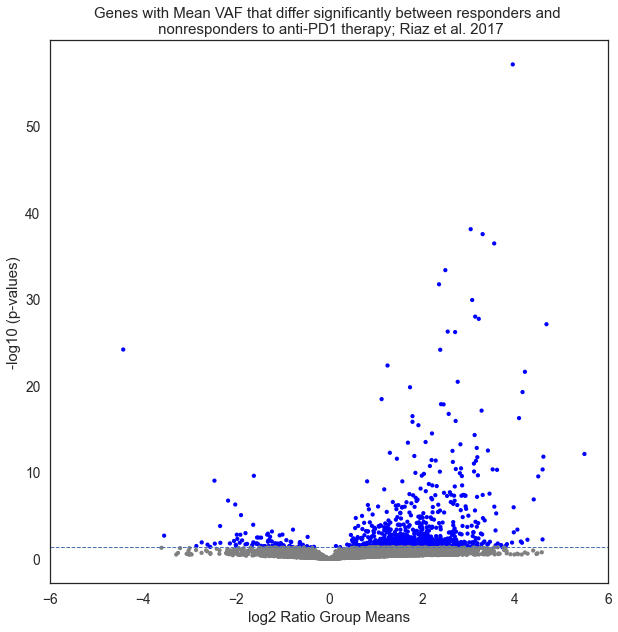

In [82]:
sns.set(font_scale = 1.25)
sns.set_style("white")
ax = sns.scatterplot(x=riaz_sorted_p['log2 Ratio Group Means'], y=riaz_sorted_p['-log10 (p-values)'],linewidth=0, alpha=1, size = 20, hue=riaz_sorted_p['significant_genes'], legend=False, palette=['grey','blue'])
ax.figure.set_size_inches((10, 10))

ax.set(xlim=(-6,6))

ax.set_title("Genes with Mean VAF that differ significantly between responders and \n nonresponders to anti-PD1 therapy; Riaz et al. 2017", loc='center') 
ax.axhline(1.30103, color='b', linestyle='--', linewidth=1)

plt.savefig('/Users/wuchh/Downloads/riaz-figure2.png', facecolor='white', bbox_inches='tight', dpi=300)

In [ ]:
riaz_sorted_p.sum(axis=0)

### TMB correction

In [ ]:
riaz_tmb = TumourMutationalBurden(mutation_table)
riaz_tmb.count_nonsynonomous_mutations(label_column="Sample_ID")

subset = list(set(riaz_tmb.nssnv_counts) & set(VAFarray.index))
VAFarray = VAFarray.loc[subset,:]
tmb_correction = [riaz_tmb.nssnv_counts[i] for i in subset]
VAFarray['tmb_correction'] = tmb_correction

import statsmodels.api as sm

values = {}

for gene in VAFarray.columns:
    X = VAFarray[[gene,'tmb_correction']]
    y = VAFarray['response']

    model = sm.OLS(y, X).fit()
    predictions = model.predict(X)
    values[gene] = model.pvalues[0]

gene = list(values.keys())
pval = list(values.values())

data = {'gene': gene, 'pval': pval}
df_rank = pd.DataFrame.from_dict(data)
genesdf = df_rank.sort_values('pval')
save = genesdf.iloc[2:,:]

save = save.reset_index()[['gene','pval']]
save.columns = ['Gene_Name','p_value']

VAFcolumns = sorted_p.reindex(save['Gene_Name'].to_list())[['responders','non-responders']]

save= save.set_index('Gene_Name')
combined = pd.concat([save,VAFcolumns],axis=1)

combined['ratio'] = combined['responders'] / combined['non-responders']
combined['logbase2ratio'] = np.log2(combined['ratio'])
combined['neglogp-val'] = -1 * np.log10(combined['p_value'])
combined

sns.set_style("white")
ax = sns.scatterplot(x=combined['logbase2ratio'], y=combined['neglogp-val'],linewidth=0,alpha=1, size = 20, legend=False, palette="deep")
ax.figure.set_size_inches((10, 10))

ax.set(xlim=(-10,10))
ax.axhline(1.30103, color='k', linestyle='--', linewidth=1)

In [ ]:
combined.loc["TIMM8A"]

In [ ]:
ax = sns.heatmap(combined[['responders','non-responders']],cmap="Blues", cbar_kws={'label': 'Mean Variant Allele Frequency', "pad": 0.1}, yticklabels=False)
ax.figure.set_size_inches((7, 7))
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_title('Hugo 2019 anti-PD1 therapy TMB corrected')

for _, spine in ax.spines.items():
    spine.set_visible(True)
    
#plt.savefig('/Users/sarahyan/Downloads/sn.png', bbox_inches='tight', dpi=300)

In [ ]:
# create instance
riaz = MutationCalls(mutation_table, clinical_features)
riaz.sort_byResponse('Response', 'Patient')

columns = {"sampleIndexColumn": 'Sample_ID', 
           "geneColumn": 'Gene_Name',
           "altReadsColumn": 'baseline_ALT_READS',
           "totalReadsColumn": 'baseline_TOTAL_READS'}
           
riaz.assign_byPatient(False, affix='%s', **columns)

In [ ]:
riaz.clinical["Response"].unique()

In [ ]:
riaz.df_toMeans(mutationRecurrence=3, response=["PR","CR"], nonresponse=["PD","SD"], geneColumn = 'Gene_Name', variantAlleleColumn = 'Variant_Allele_Frequency')

In [ ]:
riaz.tTest()
# filter p-values
sorted_pvals = riaz.sortedpVals
means = riaz.means

indicesSignificantGenes = sorted_pvals[sorted_pvals <= 1].index
sorted_p = means.reindex(indicesSignificantGenes)
sorted_p[sorted_p.eq(0)] = np.nan

In [ ]:
sorted_p

In [ ]:
# generate visualisation of sorted dataframe (side-by-side; TODO)
ax = sns.heatmap(sorted_p,cmap="Blues", cbar_kws={'label': 'Mean Variant Allele Frequency', "pad": 0.1}, yticklabels=False)
ax.figure.set_size_inches((5, 7))
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_title('Riaz 2017 anti-PD1 therapy')

for _, spine in ax.spines.items():
    spine.set_visible(True)
    
# plt.savefig('/Users/sarahyan/Downloads/antiCTLA4_riaz2017.png',facecolor=ax.get_facecolor(), bbox_inches='tight', dpi=300)

In [ ]:
sorted_p.reindex(hug_dom_genes).sort_values(by="p-value").to_csv("/Users/dch/Downloads/overlaps.csv")

In [ ]:
sorted_p["p-values"] = sorted_pvals
sorted_p.columns = ['responders','non-responders','p-value']

In [ ]:
riaz_sort = sorted_p

In [ ]:
sorted_p.to_csv("/users/dch/downloads/riaz.tsv")

In [ ]:
sorted_p.to_csv("riaz_2017_anti-pd1_37patients_rankedpval_Ttest.csv")

In [ ]:
riaz.mutation[riaz.mutation["Gene.refGene"] == "LOC100630923;PRKRIP1"]

In [ ]:
riaz.response

## comparison

In [ ]:
significant_hugo = hugo_sorted_p[hugo_sorted_p["significant_genes"] == 1].index.tolist()
significant_riaz = riaz_sorted_p[riaz_sorted_p["significant_genes"] == 1].index.tolist()

In [ ]:
hugo_sorted_p.reset_index(inplace=True)
hugo_sorted_p["overlapping genes"] = [0] * hugo_sorted_p.shape[0]
hugo_sorted_p.loc[hugo_sorted_p["index"].isin(significant_riaz),"overlapping genes"] = 1
hugo_sorted_p.sort_values(by="overlapping genes", inplace=True)

In [ ]:
sns.set(font_scale = 1.25)
sns.set_style("white")
ax = sns.scatterplot(x=hugo_sorted_p['log2 Ratio Group Means'], y=hugo_sorted_p['-log10 (p-values)'],linewidth=0, alpha=1, size = 20, hue=hugo_sorted_p['overlapping genes'], legend=False, palette='deep')
ax.figure.set_size_inches((10, 10))

ax.set_title("Genes (P-value ≤ 0.05) from Riaz 2017 Dataset Observed in Hugo 2016 Dataset")
ax.axhline(1.30103, color='k', linestyle='--', linewidth=1)

plt.savefig('/Users/dch/Downloads/riaz_variants_in_hugo.png', bbox_inches='tight', dpi=300)

In [ ]:
riaz_sorted_p.reset_index(inplace=True)
riaz_sorted_p["overlapping genes"] = [0] * riaz_sorted_p.shape[0]
riaz_sorted_p.loc[riaz_sorted_p["index"].isin(significant_hugo),"overlapping genes"] = 1
riaz_sorted_p.sort_values(by="overlapping genes", inplace=True)

In [ ]:
sns.set(font_scale = 1.25)
sns.set_style("white")
ax = sns.scatterplot(x=riaz_sorted_p['log2 Ratio Group Means'], y=riaz_sorted_p['-log10 (p-values)'],linewidth=0, alpha=1, size = 20, hue=riaz_sorted_p['overlapping genes'], legend=False, palette='deep')
ax.figure.set_size_inches((10, 10))

ax.set(xlim=(-10,10))

ax.set_title("Genes (P-value ≤ 0.05) from Hugo 2016 Dataset Observed in Riaz 2017 Dataset")
ax.axhline(1.30103, color='k', linestyle='--', linewidth=1)

plt.savefig('/Users/dch/Downloads/hugo_variants_in_riaz.png', bbox_inches='tight', dpi=300)

## Color by GO term